In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

###Question 1

In [2]:
source_data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

df = pd.read_csv(source_data)
df.head(10)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500
5,BMW,1 Series,2012,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,31200
6,BMW,1 Series,2012,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,26,17,3916,44100
7,BMW,1 Series,2012,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,39300
8,BMW,1 Series,2012,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,36900
9,BMW,1 Series,2013,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,27,18,3916,37200


In [3]:
def data_preparation(df):
    df_filter = df[["MSRP",
                    "Make",
                    "Model",
                    "Year",
                    "Engine HP",
                    "Engine Cylinders",
                    "Transmission Type",
                    "Vehicle Style",
                    "highway MPG",
                    "city mpg"]].copy()

    df_filter.columns = df_filter.columns.str.replace(' ', '_').str.lower()

    df_filter.fillna(0, inplace=True)

    df_filter.rename(columns={'msrp': 'price'}, inplace=True)

    return df_filter

df_cleaned = data_preparation(df)

### Question 1

In [4]:
most_freq = df_cleaned['transmission_type'].value_counts()
print(f"{most_freq.index[0]} is the mode for transmission type ({most_freq[0]} observations)")

AUTOMATIC is the mode for transmission type (8266 observations)


### Question 2

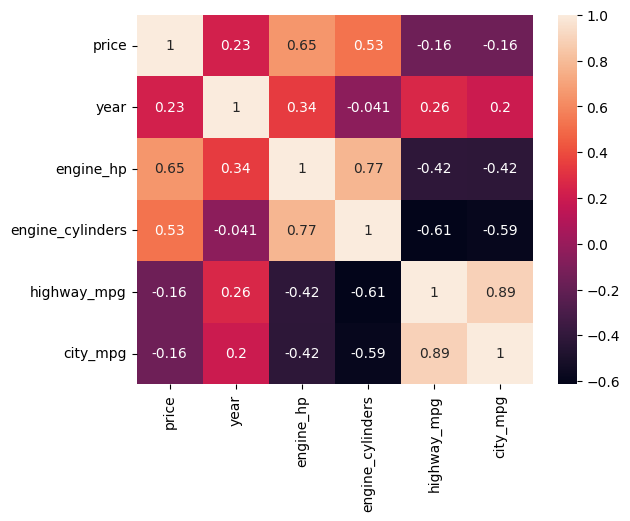

In [5]:
df_corr = df_cleaned.select_dtypes(include='number').corr()
sns.heatmap(df_corr, annot=True)
plt.show()

In [6]:
attr_correlation = df_corr.mask(np.tril(np.ones(df_corr.shape)).astype(bool))
attr_correlation_ = attr_correlation.abs().unstack().sort_values()
df_attr_corr = attr_correlation_[attr_correlation_ < 1].sort_values(ascending=False).to_frame().reset_index().rename(columns={'level_0': 'feature 1', 'level_1': 'feature 2', 0: 'correlation'})

print(f"{df_attr_corr['feature 1'][:1].iloc[0]} and {df_attr_corr['feature 2'][:1].iloc[0]} has highest correlation score of {df_attr_corr['correlation'][:1].iloc[0]:.3f}")


city_mpg and highway_mpg has highest correlation score of 0.887


In [7]:
average_price = df_cleaned['price'].mean()

df_cleaned['above_average'] = (df_cleaned['price'] > average_price).astype(int)
df_cleaned

,price,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,46135,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,40650,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,36350,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,29450,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,34500,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0
...,...,...,...,...,...,...,...,...,...,...,...
11909,46120,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,1
11910,56670,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,1
11911,50620,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,1
11912,50920,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,1


In [8]:
data_cols_character_ = df_cleaned.select_dtypes(include='object').columns
dv = DictVectorizer(sparse=False)

X = df_cleaned.drop(columns=['above_average'])
X_dicts = X.to_dict(orient='records')
X_oneh = dv.fit_transform(X_dicts)
# X_oneh = pd.get_dummies(X, prefix=[col for col in data_cols_character_], columns=[col for col in data_cols_character_])
y = df_cleaned['above_average']

X_train_mi, X_temp_mi, y_train_mi, y_temp_mi = train_test_split(X, y, test_size=0.4, random_state=42)
X_train, X_temp, y_train, y_temp = train_test_split(pd.DataFrame(X_oneh, columns=dv.get_feature_names_out()), y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape[0]} ({(X_train.shape[0]/ X.shape[0])*100:.2f}%)\n\
Val: {X_val.shape[0]} ({(X_val.shape[0]/ X.shape[0])*100:.2f}%)\n\
Test: {X_test.shape[0]} ({(X_test.shape[0]/ X.shape[0])*100:.2f}%)")


Train: 7148 (60.00%)
Val: 2383 (20.00%)
Test: 2383 (20.00%)


### Question 3

In [9]:
for col in df_cleaned.select_dtypes(include='object').columns:
  mi_scores = mutual_info_score(y_train_mi.astype('category'), X_train_mi[col])
  print(f"above_average vs {col}: {mi_scores:.2f}")

above_average vs make: 0.24
above_average vs model: 0.46
above_average vs transmission_type: 0.02
above_average vs vehicle_style: 0.08


### Question 4

In [10]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
accuracy = round(accuracy_score(y_val, y_val_pred), 2)

print(f"Accuracy on the validation dataset: {accuracy*100:.2f} %")

Accuracy on the validation dataset: 100.00 %


### Question 5

In [11]:
model.fit(X_train[[col for col in X_train.columns if col != 'year']], y_train)

y_val_pred = model.predict(X_val[[col for col in X_train.columns if col != 'year']])
accuracy_w_year = round(accuracy_score(y_val, y_val_pred), 2)

print(f"Exclude year variable\n\
Accuracy: {(accuracy_w_year*100):.2f}\n\
Accuracy diff: {(accuracy*100) - (accuracy_w_year*100):.2f} %")

Exclude year variable
Accuracy: 94.00
Accuracy diff: 6.00 %


In [12]:
model.fit(X_train[[col for col in X_train.columns if col != 'engine_hp']], y_train)

y_val_pred = model.predict(X_val[[col for col in X_train.columns if col != 'engine_hp']])
accuracy_w_enginehp = round(accuracy_score(y_val, y_val_pred), 2)

print(f"Exclude engine_hp variable\n\
Accuracy: {(accuracy_w_enginehp*100):.2f}\n\
Accuracy diff: {(accuracy*100) - (accuracy_w_enginehp*100):.2f} %")

Exclude engine_hp variable
Accuracy: 100.00
Accuracy diff: 0.00 %


In [13]:
model.fit(X_train[[col for col in X_train.columns if 'transmission_type' not in col]], y_train)

y_val_pred = model.predict(X_val[[col for col in X_train.columns if 'transmission_type' not in col]])
accuracy_w_transtype = round(accuracy_score(y_val, y_val_pred), 2)

print(f"Exclude transmission_type variable\n\
Accuracy: {(accuracy_w_transtype*100):.2f}\n\
Accuracy diff: {(accuracy*100) - (accuracy_w_transtype*100):.2f} %")

Exclude transmission_type variable
Accuracy: 100.00
Accuracy diff: 0.00 %


In [14]:
model.fit(X_train[[col for col in X_train.columns if col != 'city_mpg']], y_train)

y_val_pred = model.predict(X_val[[col for col in X_train.columns if col != 'city_mpg']])
accuracy_w_citympg = round(accuracy_score(y_val, y_val_pred), 2)

print(f"Exclude city_mpg variable\n\
Accuracy: {(accuracy_w_citympg*100):.2f}\n\
Accuracy diff: {(accuracy*100) - (accuracy_w_citympg*100):.2f} %")

Exclude city_mpg variable
Accuracy: 100.00
Accuracy diff: 0.00 %


### Question 6

In [15]:
data_cols_character_ = df_cleaned.select_dtypes(include='object').columns
dv_ = DictVectorizer(sparse=False)

X_ = df_cleaned.drop(columns=['price'])
X_dicts_ = X_.to_dict(orient='records')
X_oneh_ = dv_.fit_transform(X_dicts_)
y_ = df_cleaned['price']

X_train_, X_temp_, y_train_, y_temp_ = train_test_split(pd.DataFrame(X_oneh_, columns=dv.get_feature_names_out()), y_, test_size=0.4, random_state=42)
X_val_, X_test_, y_val_, y_test_ = train_test_split(X_temp_, y_temp_, test_size=0.5, random_state=42)

print(f"Train: {X_train_.shape[0]} ({(X_train_.shape[0]/ X_.shape[0])*100:.2f}%)\n\
Val: {X_val_.shape[0]} ({(X_val_.shape[0]/ X_.shape[0])*100:.2f}%)\n\
Test: {X_test_.shape[0]} ({(X_test_.shape[0]/ X_.shape[0])*100:.2f}%)")


Train: 7148 (60.00%)
Val: 2383 (20.00%)
Test: 2383 (20.00%)


In [16]:
best_alpha = None
best_rmse = float('inf')

for alpha in [0, 0.01, 0.1, 1, 10]:
    ridge_model = Ridge(alpha=alpha, solver='sag', random_state=42)
    ridge_model.fit(X_train_, y_train_)

    y_pred_ = ridge_model.predict(X_val_)

    rmse = np.sqrt(mean_squared_error(y_val_, y_pred_))

    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha

best_rmse = round(best_rmse, 3)

print(f"The best alpha with the smallest RMSE on the validation set is {best_alpha} (RMSE: {best_rmse})")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The best alpha with the smallest RMSE on the validation set is 0 (RMSE: 46859.168)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
